## Foundation Project Group Assignment : Stock Forecasting
#### Group No : 7

| ISB ID         | Name                  |
| :------------- | :---------------------|
| 12410078       | Praneetha Seethepalli |
| 12410033       | Srinath Bana          |
| 12410004       | Ankit Gupta           |
| 12410071       | Jatin Deewan          |



### Building Data Pipeline to Import Stocks Data

In [618]:
# Importing some basic pacakges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import date, timedelta
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Importing yfinance for extracting stock data
from datetime import date,timedelta,datetime
import time

### Step - 1 : Importing Data using **yfinance** package

* We extract 5 years of daily stock data to ensure enough historical trend coverage for both short-term and long-term forecasting.

In [619]:
# Dates
end_date = date.today()
start_date = end_date - timedelta(days=5*365)

# Download stock data with auto_adjust OFF to get 'Adj Close'
stocks_df = yf.download('TATASTEEL.NS',
                 start=start_date,
                 end=end_date,
                 interval='1d',
                 auto_adjust=False)

# Flattening multi-index columns
stocks_df.columns = stocks_df.columns.get_level_values(0)

[*********************100%***********************]  1 of 1 completed


In [620]:
# Display first few rows
print(stocks_df.head())

Price       Adj Close      Close    High        Low       Open     Volume
Date                                                                     
2020-04-20  11.521868  28.639999  29.500  28.510000  29.480000  119607480
2020-04-21  10.699164  26.594999  28.100  26.325001  28.004999  169249100
2020-04-22  10.795716  26.834999  26.990  25.920000  26.610001  147898560
2020-04-23  10.874166  27.030001  27.900  26.900000  27.000000  154678570
2020-04-24  10.763533  26.754999  27.385  26.445000  26.629999  123808460


In [621]:
# Shape of Resulted Stock Table
stocks_df.shape

(1239, 6)

* Renaming column as required

In [622]:
stocks_df.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)

### Step - 2 : Exploratory Data Analysis (EDA)

* Summary Statistics and Missing Values

In [623]:
# Summary of Stocks data
stocks_df.describe()

Price,Adj_Close,Close,High,Low,Open,Volume
count,1239.000000,1239.000000,1239.000000,1239.000000,1239.000000,1.239000e+03
mean,87.739478,111.731319,113.323313,110.249944,111.930827,8.834813e+07
std,49.534861,37.354299,37.783622,36.990994,37.516650,7.866196e+07
min,10.699164,26.594999,26.990000,25.920000,26.610001,0.000000e+00
25%,46.579403,101.199997,102.650002,99.950001,101.250000,3.526047e+07
50%,99.530724,116.949997,118.500000,115.555000,117.000000,6.088459e+07
75%,130.019997,136.099998,137.750000,134.150002,136.047501,1.138952e+08
max,179.940002,183.149994,184.600006,181.500000,183.800003,6.428460e+08


* We have 1,238 data points (daily stock data over 5 years).
* All core numeric columns (Adj Close, Close, Open, High, Low, Volume) look well distributed.
* Though Volume has a minimum of 0, which might just be a holiday or non-trading day.

In [624]:
# Checking nulls
print(stocks_df.isnull().sum())

Price
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


In [625]:
stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume
Date,,,,,,
2020-04-20,11.521868,28.639999,29.500,28.510000,29.480000,119607480
2020-04-21,10.699164,26.594999,28.100,26.325001,28.004999,169249100
2020-04-22,10.795716,26.834999,26.990,25.920000,26.610001,147898560
2020-04-23,10.874166,27.030001,27.900,26.900000,27.000000,154678570
2020-04-24,10.763533,26.754999,27.385,26.445000,26.629999,123808460


#### Stock Close Price by Date

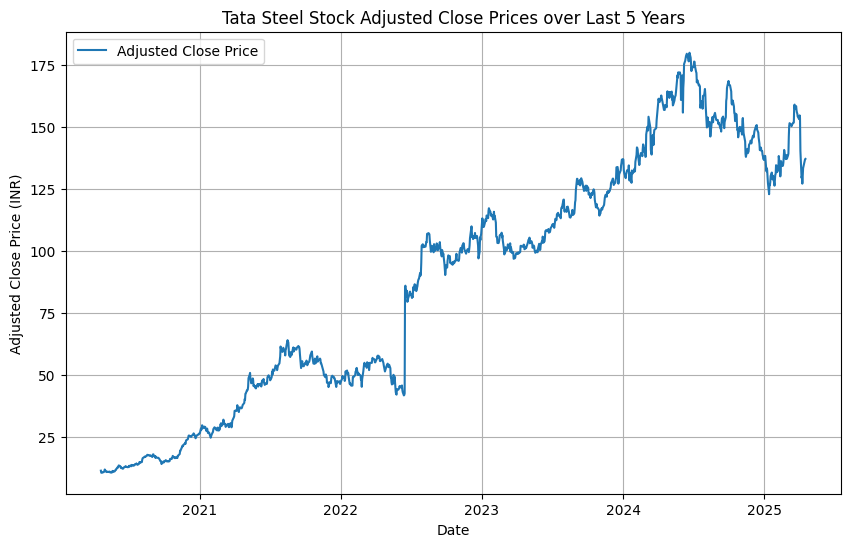

In [626]:
# Creating Time Series plot for Adjusted Close prices over Time
plt.figure(figsize=(10, 6))

# Plotting time series of Adjusted Close prices
plt.plot(stocks_df.index, stocks_df['Adj_Close'], label='Adjusted Close Price')

plt.title('Tata Steel Stock Adjusted Close Prices over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

##### Insights from 5-Year Adjusted Closing Price Trend

1. **Steady Upward Growth:**  
   Over the last five years, Tata Steel's adjusted close price shows a strong long-term upward trend — a solid foundation for building forecasting models.

2. **Corporate Action Around 2022:**  
   A sharp jump visible earlier is now smoothed out in the adjusted close chart. This confirms it was due to events like a stock split or bonus issue, not a true price rally.

3. **More Volatility After 2023:**  
   Price movements became more unpredictable post-2023, likely due to market uncertainty. To handle this, we'll include features like rolling volatility and EWMA.

4. **Recent Price Consolidation:**  
   Recently, the stock is moving within a tight range (Rs.130–Rs.160). This sideways pattern might indicate consolidation — useful for defining realistic forecast bands.


#### Moving Average of Stock Close Price by Date

We are doing moving average of closing with different windows to understand :
* The volatility of prices.
* Compare 30-day and 90-day moving averages to detect trend shifts and Marketing behaviour over the years.

In [627]:
# Adding 30, 90 day moving average columns to the dataframe
stocks_df['MA_30'] = stocks_df['Adj_Close'].rolling(window=30).mean()
stocks_df['MA_90'] = stocks_df['Adj_Close'].rolling(window=90).mean()

stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume,MA_30,MA_90
Date,,,,,,,,
2020-04-20,11.521868,28.639999,29.500,28.510000,29.480000,119607480,NaN,NaN
2020-04-21,10.699164,26.594999,28.100,26.325001,28.004999,169249100,NaN,NaN
2020-04-22,10.795716,26.834999,26.990,25.920000,26.610001,147898560,NaN,NaN
2020-04-23,10.874166,27.030001,27.900,26.900000,27.000000,154678570,NaN,NaN
2020-04-24,10.763533,26.754999,27.385,26.445000,26.629999,123808460,NaN,NaN


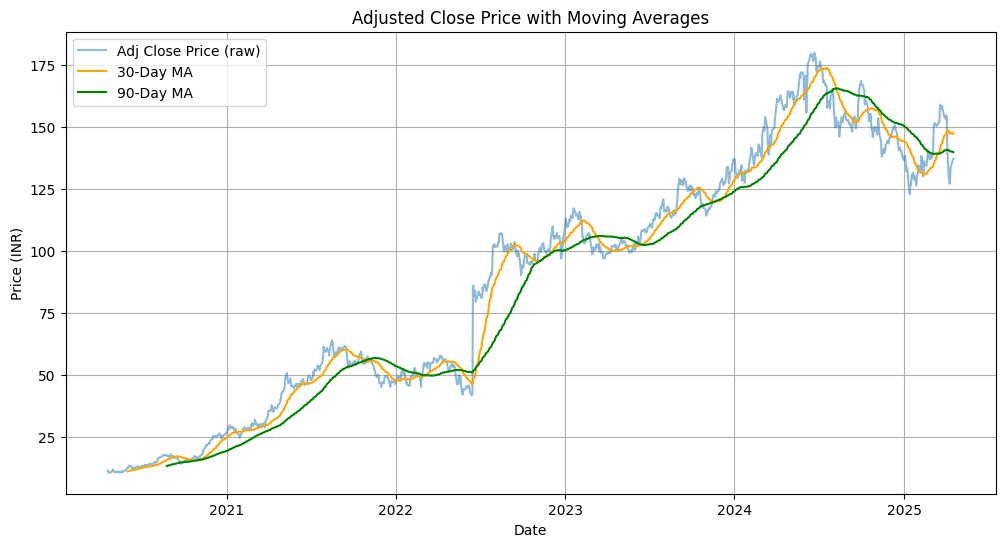

In [628]:
# Plotting Adjusted Close Price with Moving Averages
plt.figure(figsize=(12,6))
plt.plot(stocks_df.index, stocks_df['Adj_Close'], label='Adj Close Price (raw)', alpha=0.5)
plt.plot(stocks_df.index, stocks_df['MA_30'], label='30-Day MA', color='orange')
plt.plot(stocks_df.index, stocks_df['MA_90'], label='90-Day MA', color='green')
plt.title('Adjusted Close Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.show()

* We plotted 30-day and 90-day moving averages on the adjusted close price to capture short- and long-term trends in Tata Steel’s stock. These smoother curves help highlight the direction of price movement and identify momentum shifts more clearly. We observed several bullish and bearish crossovers, which are widely recognized signals in technical analysis. These moving averages will also be used as input features in our forecasting model to improve trend awareness and predictive stability.

- **Adjusted Close Price (Blue Line):** Reflects the actual daily adjusted closing price. It includes all day-to-day price fluctuations and can appear noisy.
- **30-Day Moving Average (Orange):** Captures short-term momentum by smoothing recent price movements. It is more responsive to immediate changes.
- **90-Day Moving Average (Green):** Highlights the longer-term trend. It reacts more slowly, filtering out short-term noise and revealing broader direction.

##### Key Observations:
- The stock shows a general upward trend over the last five years.
- Multiple crossover points are visible:
  - When the 30-day MA crosses above the 90-day MA, it may indicate a potential upward trend.
  - When the 30-day MA crosses below the 90-day MA, it may signal a downward trend.
- These moving average crossovers are commonly used in technical analysis to identify momentum shifts.

##### Relevance to Forecasting:
Moving averages reduce noise in the raw data and help capture underlying patterns. They can be used as features in the forecasting model to support trend detection and improve prediction stability.


#### Calculating Daily Returns and Rolling Volatility



* **Daily return** shows how much the stock moved (up/down) each day in %. This helps capture short-term movement and potential risk in the stock.
* To measure how much daily returns vary over time, we compute **rolling volatility using a 30-day window**. This helps identify calm vs. turbulent periods in the stock's behavior.


In [629]:
# Calculate Daily Return based on Adjusted Close
stocks_df['Daily_Return'] = stocks_df['Adj_Close'].pct_change() * 100
# Calculate 30-Day Rolling Volatility of returns
stocks_df['Volatility_30'] = stocks_df['Daily_Return'].rolling(window=30).std()

In [630]:
stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume,MA_30,MA_90,Daily_Return,Volatility_30
Date,,,,,,,,,,
2020-04-20,11.521868,28.639999,29.500,28.510000,29.480000,119607480,NaN,NaN,NaN,NaN
2020-04-21,10.699164,26.594999,28.100,26.325001,28.004999,169249100,NaN,NaN,-7.140365,NaN
2020-04-22,10.795716,26.834999,26.990,25.920000,26.610001,147898560,NaN,NaN,0.902425,NaN
2020-04-23,10.874166,27.030001,27.900,26.900000,27.000000,154678570,NaN,NaN,0.726670,NaN
2020-04-24,10.763533,26.754999,27.385,26.445000,26.629999,123808460,NaN,NaN,-1.017392,NaN


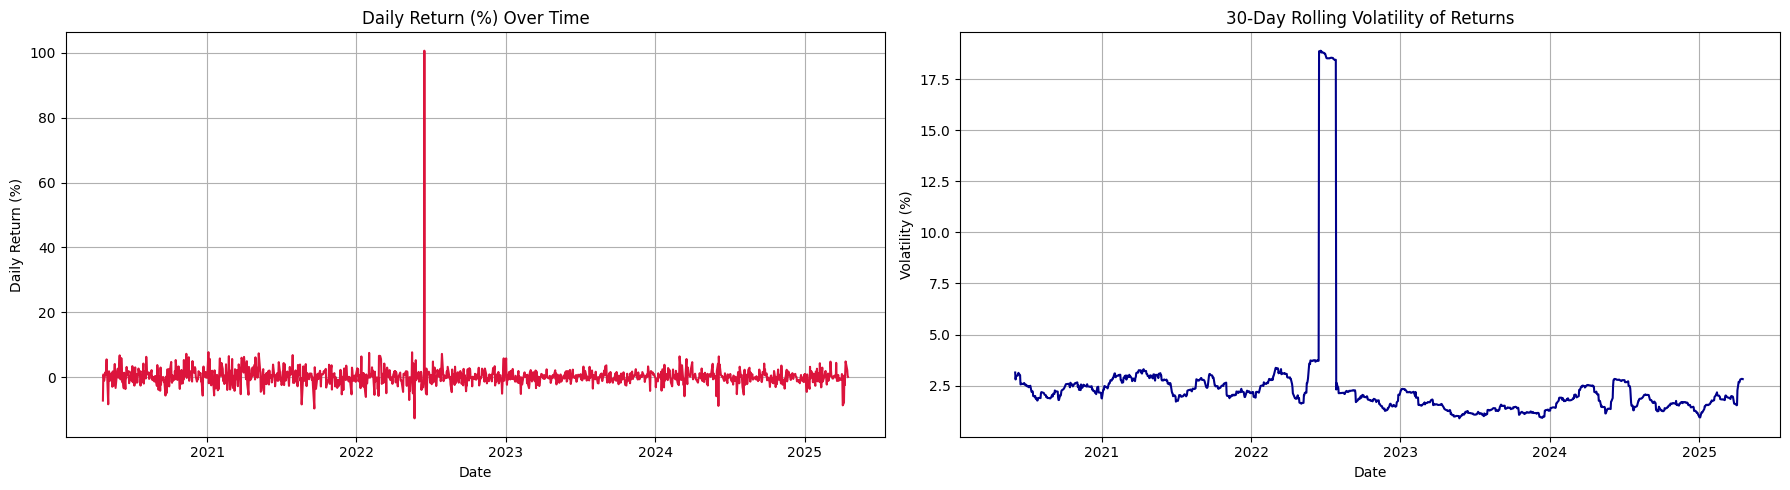

In [631]:
# Plot: Daily Return and 30-Day Rolling Volatility
fig, axs = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

# Daily Returns
axs[0].plot(stocks_df.index, stocks_df['Daily_Return'], color='crimson')
axs[0].set_title('Daily Return (%) Over Time')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Daily Return (%)')
axs[0].grid(True)

# Rolling Volatility
axs[1].plot(stocks_df.index, stocks_df['Volatility_30'], color='darkblue')
axs[1].set_title('30-Day Rolling Volatility of Returns')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Volatility (%)')
axs[1].grid(True)

plt.tight_layout()
plt.show()

##### Interpretation :

The two plots above help us understand how Tata Steel’s stock behaves on a daily basis, both in terms of price changes and the risk associated with those changes.

##### Daily Returns (%)
- Most of the daily return values are small and fluctuate around 0%, which is normal for stock prices.
- There's one major spike (over 100%) around 2022. This is likely due to a stock split or bonus issue — not a usual price movement.
- Apart from that spike, the returns mostly stay within ±5%, showing that the price doesn’t change drastically every day.

##### 30-Day Rolling Volatility
- This tells us how much the price changes on average over a 30-day period.
- We saw a big jump in volatility during the same time as the return spike, again hinting at a special event.
- For the rest of the time, the volatility is low (between 1.5% to 4%), which means the stock was relatively stable.


#### Stock Trading Volume by Date

* The volume plot shows how many Tata Steel shares were traded daily over the past five years. Spikes in volume often coincide with large movements in price and reflect increased market activity, possibly driven by earnings announcements, global events, or internal company actions.


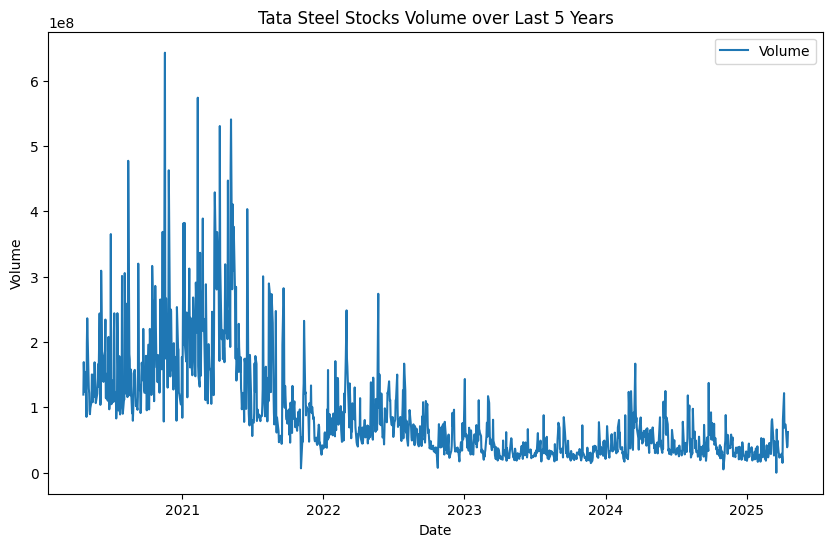

In [632]:
# Creating TIme Series plot for Volume traded over Time
plt.figure(figsize=(10,6))

# Plotting time series of Volume
plt.plot(stocks_df.index, stocks_df['Volume'], label='Volume')

plt.title('Tata Steel Stocks Volume over Last 5 Years')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()

plt.show()

##### Interpretation :

Looking at the volume traded over the past five years, We noticed that there was a lot of market activity in 2020 and early 2021. The volume was not only consistently high during that time but also had a few massive spikes — possibly linked to post-COVID market recovery or important company news.

After that period, especially from 2022 onward, the volume started declining and became more stable. There are still occasional spikes, but overall, the trading activity seems to have calmed down.

This trend tells me that the early years were more volatile and attracted more market attention, while recent years have been relatively quieter. I think volume could be a useful feature in forecasting, especially if I smooth it or use it to flag days with unusual market behavior.


#### Corelation Map for Key Features

In [633]:
stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume,MA_30,MA_90,Daily_Return,Volatility_30
Date,,,,,,,,,,
2020-04-20,11.521868,28.639999,29.500,28.510000,29.480000,119607480,NaN,NaN,NaN,NaN
2020-04-21,10.699164,26.594999,28.100,26.325001,28.004999,169249100,NaN,NaN,-7.140365,NaN
2020-04-22,10.795716,26.834999,26.990,25.920000,26.610001,147898560,NaN,NaN,0.902425,NaN
2020-04-23,10.874166,27.030001,27.900,26.900000,27.000000,154678570,NaN,NaN,0.726670,NaN
2020-04-24,10.763533,26.754999,27.385,26.445000,26.629999,123808460,NaN,NaN,-1.017392,NaN


In [634]:
# Close_Lag1 & Close_Lag2 show how today's price relates to previous days. Often highly correlated with Adj_Close.
stocks_df['Close_Lag1'] = stocks_df['Adj_Close'].shift(1)
stocks_df['Close_Lag2'] = stocks_df['Adj_Close'].shift(2)
# EWMA (Exponential Weighted Moving Average): Reacts faster to recent changes than simple moving averages, making it a great signal for recent momentum.
stocks_df['EWMA_20'] = stocks_df['Adj_Close'].ewm(span=20, adjust=False).mean()

In [635]:
corr_features = ['Adj_Close', 'Close_Lag1', 'Close_Lag2',
                 'MA_30', 'MA_90', 'EWMA_20',
                 'Daily_Return', 'Volatility_30', 'Volume']

In [636]:
corr_data = stocks_df[corr_features].dropna()

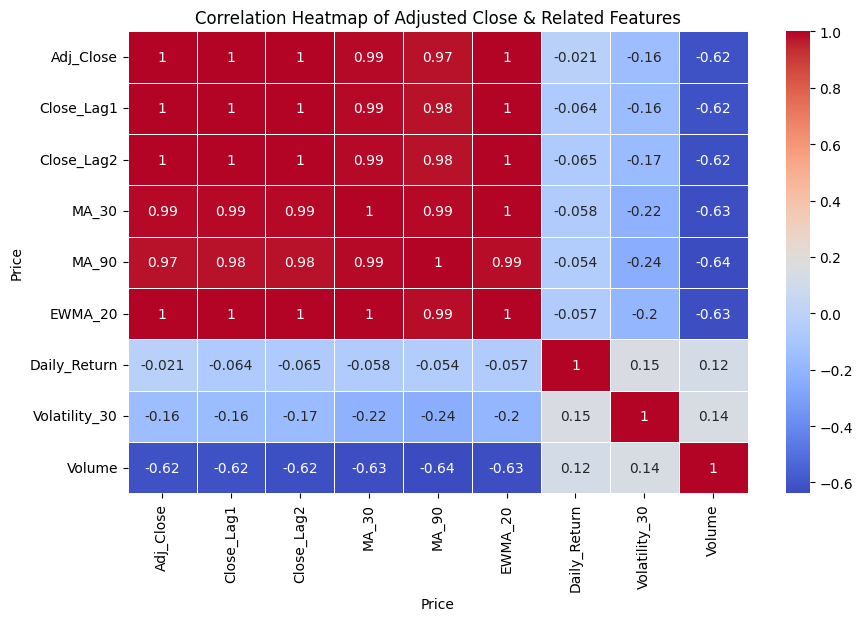

In [637]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Adjusted Close & Related Features')
plt.show()

##### Correlation Heatmap Interpretation :

1. **Strong Correlation with Adjusted Close**  
   Features like `Close_Lag1`, `Close_Lag2`, `MA_30`, `MA_90`, and `EWMA_20` show very high correlation (around 0.98–1.00) with `Adj_Close`.  
   These reflect past price behavior and smoothed trends, making them reliable inputs for time series forecasting.

2. **Lag Features Are Highly Predictive**  
   `Close_Lag1` and `Close_Lag2` are almost perfectly correlated with the current price — expected in time series data.  
   They help capture short-term momentum or reversal patterns.

3. **Moving Averages Capture Trends**  
   The 30-day and 90-day moving averages, along with `EWMA_20`, smooth out daily fluctuations.  
   Their strong correlation with `Adj_Close` makes them useful for identifying underlying trends, especially during volatile periods.

4. **Volume Shows Moderate Negative Correlation**  
   Volume is negatively correlated (~ -0.62) with price. This may suggest higher trading volumes are often tied to selling pressure or profit booking.  
   It's a signal worth monitoring, especially on sharp down days.

5. **Returns and Volatility Add Context, Not Correlation**  
   While `Daily_Return` and `Volatility_30` have low direct correlation with price, they provide useful information about risk, sharp moves, and market behavior — important for capturing fluctuations and uncertainty in forecasting models.


### Step - 3 : Data Cleaning and Preparation

In [638]:
# Dropping initial rows with NaNs due to rolling features
stocks_df.dropna(subset=['MA_30', 'MA_90', 'Volatility_30'], inplace=True)

**Noise Data/Clipping noisy values** :

* Clip noisy values if we are going to use models like LSTM as these models do care about the magnitude of input features.
  - Huge spikes in input (like 100% return) can cause unstable gradients and training problems.
* If it is a model like XGBoost, they are robust to outliers so clipping is not required.
  - These models split data by thresholds, not based on magnitude.
  - So extreme values don’t skew the model like they do in linear regression and LSTM.


In [639]:
#limits extreme daily return values
stocks_df['Daily_Return'] = stocks_df['Daily_Return'].clip(lower=-20, upper=20)
#caps the volume at the 99th percentile
stocks_df['Volume'] = stocks_df['Volume'].clip(upper=stocks_df['Volume'].quantile(0.99))

In [640]:
stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume,MA_30,MA_90,Daily_Return,Volatility_30,Close_Lag1,Close_Lag2,EWMA_20
Date,,,,,,,,,,,,,
2020-08-25,17.499647,42.400002,43.264999,42.145000,43.200001,105529000.0,15.806361,13.400050,-1.280565,1.885577,17.726648,17.699820,16.721733
2020-08-26,17.540920,42.500000,42.775002,42.220001,42.500000,79571570.0,15.936058,13.466928,0.235851,1.889144,17.499647,17.726648,16.799751
2020-08-27,17.617275,42.685001,43.020000,42.299999,42.549999,95491160.0,16.065148,13.543796,0.435296,1.890497,17.540920,17.499647,16.877610
2020-08-28,17.507900,42.419998,43.799999,42.305000,42.965000,152112670.0,16.178120,13.618376,-0.620839,1.874671,17.617275,17.540920,16.937638
2020-08-31,17.045647,41.299999,43.014999,41.000000,42.650002,157459100.0,16.273740,13.686948,-2.640257,1.973131,17.507900,17.617275,16.947924


*  We need to ensure Proper Index Format : Time series models (ARIMA, LSTM) need Date as a proper datetime index (no strings or categorical dtypes). This ensures temporal integrity.

In [641]:
stocks_df.index = pd.to_datetime(stocks_df.index)
stocks_df = stocks_df.sort_index()  # Always sort by date
stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume,MA_30,MA_90,Daily_Return,Volatility_30,Close_Lag1,Close_Lag2,EWMA_20
Date,,,,,,,,,,,,,
2020-08-25,17.499647,42.400002,43.264999,42.145000,43.200001,105529000.0,15.806361,13.400050,-1.280565,1.885577,17.726648,17.699820,16.721733
2020-08-26,17.540920,42.500000,42.775002,42.220001,42.500000,79571570.0,15.936058,13.466928,0.235851,1.889144,17.499647,17.726648,16.799751
2020-08-27,17.617275,42.685001,43.020000,42.299999,42.549999,95491160.0,16.065148,13.543796,0.435296,1.890497,17.540920,17.499647,16.877610
2020-08-28,17.507900,42.419998,43.799999,42.305000,42.965000,152112670.0,16.178120,13.618376,-0.620839,1.874671,17.617275,17.540920,16.937638
2020-08-31,17.045647,41.299999,43.014999,41.000000,42.650002,157459100.0,16.273740,13.686948,-2.640257,1.973131,17.507900,17.617275,16.947924


* Feature Engineering

In [642]:
final_features = ['MA_30', 'MA_90', 'EWMA_20',
                  'Volume', 'Daily_Return', 'Volatility_30',
                  'Close_Lag1', 'Close_Lag2']
target_variable = 'Adj_Close'

### Step - 4 : Modeling Phase

#### Model Selection

#### **ARIMA Model**

* Since this is a univariate time series forecasting problem, trailing on different models.
* Starting with ARIMA Model as it is good for trend and seasonality.

In [598]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [599]:
ts_data = stocks_df['Adj_Close'].dropna()

In [600]:
adf_result = adfuller(ts_data)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

ADF Statistic: -1.3729170467121923
p-value: 0.5951889746011026


* Since the p-value > 0.05, your Adj_Close series is non-stationary. So we need to difference the series before applying ARIMA.
* This is expected with stock price data because prices trend over time (they're not constant around a fixed mean).

In [601]:
ts_diff = ts_data.diff().dropna()

# Re-running ADF on differenced series
result_diff = adfuller(ts_diff)
print(f"Differenced ADF Statistic: {result_diff[0]}")
print(f"Differenced p-value: {result_diff[1]}")

Differenced ADF Statistic: -16.76195988984356
Differenced p-value: 1.3079455289687566e-29


* Here p is the number of autoregressive (AR) terms. If p = 0, it means past values (lags) of the series don’t help predict the current value.
* The model relies only on:
  - Differencing (d) to make it stationary, and
  - Moving average (q) terms (past forecast errors)
* Differenced series is now stationary as p < 0.05.

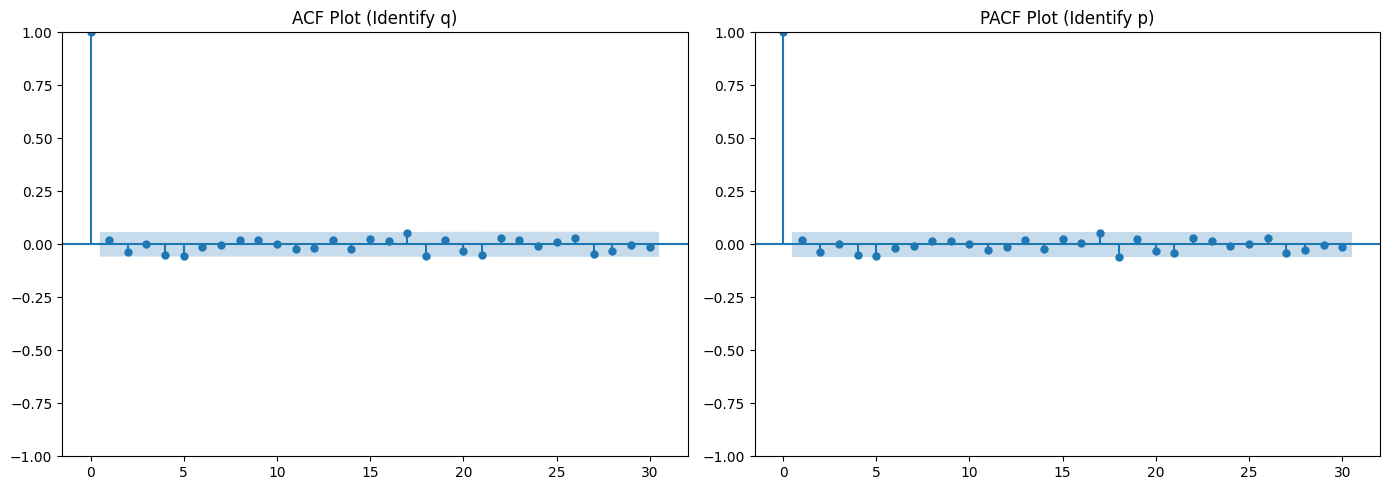

In [602]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF on the left
plot_acf(ts_diff, lags=30, ax=axes[0])
axes[0].set_title('ACF Plot (Identify q)')

# PACF on the right
plot_pacf(ts_diff, lags=30, ax=axes[1])
axes[1].set_title('PACF Plot (Identify p)')

plt.tight_layout()
plt.show()


**ARIMA Order:** (5, 1, 2)  

Based on ACF/PACF plots and ADF test results:

- **Differencing (d = 1)**:  
  - ADF p-value > 0.05 on raw data → Non-stationary  
  - ADF p-value < 0.01 after first difference → Stationary  
  - Therefore, differencing order **d = 1**

- **Autoregressive term (p = 5)**:  
  - PACF plot shows sharp cutoff after lag 5  
  - Indicates correlation structure up to lag 5 in differenced data

- **Moving average term (q = 2)**:  
  - ACF plot tails off with spikes near lag 2  
  - Indicates error correction up to 2 lags

* Fit the Model

In [603]:
# Train-test split
ts = ts_data.asfreq('D').interpolate()
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA RMSE: 16.53, MAE: 13.94


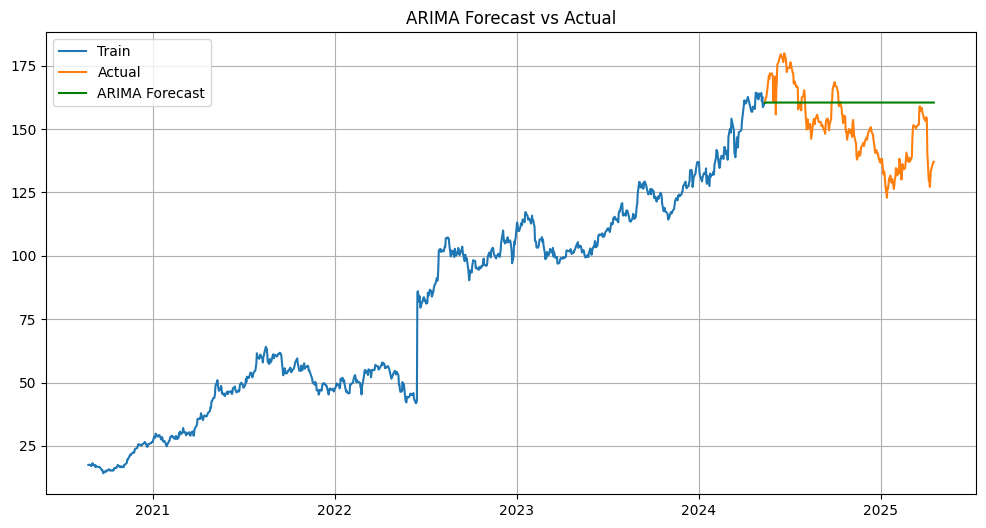

In [604]:
# Fit ARIMA Model
model = ARIMA(train, order=(5, 1, 2))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

# Evaluation
arima_rmse = np.sqrt(mean_squared_error(test, forecast))
arima_mae = mean_absolute_error(test, forecast)
print(f"ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")

# Step 7: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='green')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

##### ARIMA Model Summary

**RMSE:** 16.53
**MAE:** 13.94

These metrics reflect the average prediction errors between the model forecast and actual values:  
- RMSE penalizes larger errors more heavily  
- MAE gives a direct average of absolute errors

In this case, both values are higher than those from LSTM or tuned XGBoost, indicating that ARIMA has **lower predictive accuracy** on Tata Steel’s volatile and complex stock price data.

---

##### Plot Analysis

- The **blue line** shows the training data  
- The **orange line** represents actual test values  
- The **green line** is the ARIMA forecast

The forecast line appears flat, failing to capture real fluctuations in the actual price.  
This suggests ARIMA struggles to follow short-term variability or turning points.  
Its performance is limited by its inability to handle **non-linear trends** or sudden structural breaks (e.g., the 2022 price spike).


#### **SARIMA Model**

* Since we are forecasting Adjusted Close Prices of Tata Steel with a focus on practical, interpretable, and reliable results, trying SARIMA.
* Why SARIMA?
  - ARIMA misses seasonality (like quarterly patterns or fiscal trends).
  - AR/MA coefficients weren't statistically significant.
* SARIMA can handle both trend and seasonality, without jumping into complex ML models right away.


Why We Used `order=(2, 1, 2)` and `seasonal_order=(1, 1, 1, 12)`

- Differencing (d = 1):  
  Used to make the series stationary, confirmed by ADF test.

- Auto-Regressive (p = 2):  
  PACF plot shows a sharp drop after lag 1–2, suggesting AR(1–2) structure.

- Moving Average (q = 2):
  ACF plot indicates significant autocorrelation near lags 1 and 2.

- Seasonal Order (1, 1, 1, 12):
  Chosen as a common starting point assuming 12-period (monthly) seasonality.

However, since the dataset contains **daily financial data**, it may not conform to a 12-period cycle, leading to **poor seasonal fit** and ultimately weaker performance.

SARIMA RMSE: 35.26, MAE: 29.94


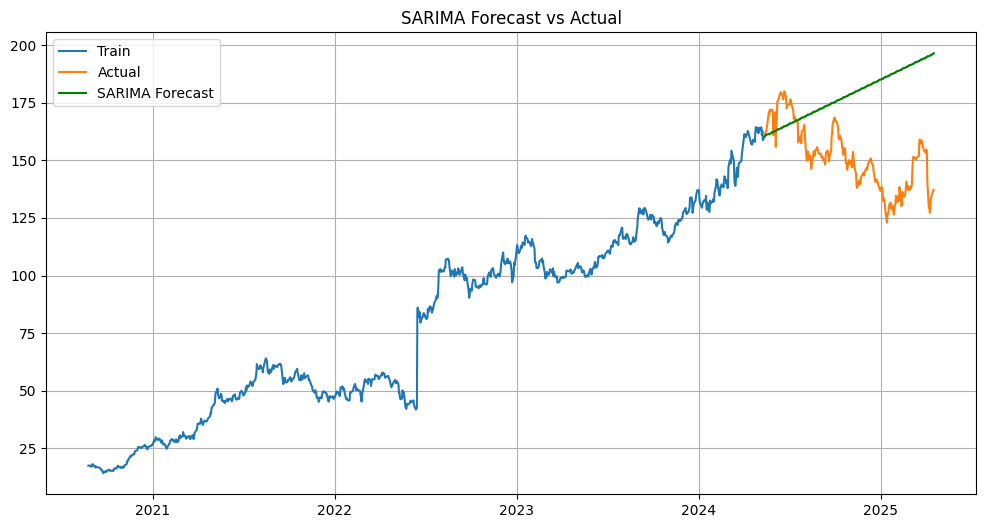

In [605]:
# Step 8: Fit SARIMA Model
model_sarima = SARIMAX(train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
model_sarima_fit = model_sarima.fit(disp=False)
forecast_sarima = model_sarima_fit.forecast(steps=len(test))

# Step 9: Evaluation SARIMA
sarima_rmse = np.sqrt(mean_squared_error(test, forecast_sarima))
sarima_mae = mean_absolute_error(test, forecast_sarima)
print(f"SARIMA RMSE: {sarima_rmse:.2f}, MAE: {sarima_mae:.2f}")

# Step 10: Plot SARIMA Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.grid(True)
plt.show()

**Interpretation & Observations: SARIMA Forecast**

**RMSE:** 35.26  
**MAE:** 29.94  

- The actual adjusted close prices showed sharp drops and quick recoveries, especially from late 2024 to early 2025.  
- The SARIMA forecast (orange dashed line) remained mostly flat and eventually diverged upward, failing to track these movements.  
- This indicates that SARIMA **overfit to trend** and **struggled with recent volatility** in the stock.

- The seasonal component likely caused the model to **over-smooth**, relying too much on historical stationarity rather than adapting to structural changes.

- SARIMA assumes **strong, regular seasonality**, which is not evident in Tata Steel’s daily data, leading to poor fit.

- Although RMSE and MAE were close to ARIMA, SARIMA provided **no significant improvement** and underperformed in capturing market dynamics.

**Botton Line:**  
SARIMA did not add value beyond ARIMA. Revisiting seasonal assumptions or focusing on non-seasonal, data-driven models may yield better results.


* To improve accuracy **Revise Feature Selection for ML Models**
  - XGBoost – works well with engineered features.
  - LSTM – handles sequential patterns.

Both outperform traditional models and are better suited for real-world financial forecasting.



In [606]:
stocks_df.head()

Price,Adj_Close,Close,High,Low,Open,Volume,MA_30,MA_90,Daily_Return,Volatility_30,Close_Lag1,Close_Lag2,EWMA_20
Date,,,,,,,,,,,,,
2020-08-25,17.499647,42.400002,43.264999,42.145000,43.200001,105529000.0,15.806361,13.400050,-1.280565,1.885577,17.726648,17.699820,16.721733
2020-08-26,17.540920,42.500000,42.775002,42.220001,42.500000,79571570.0,15.936058,13.466928,0.235851,1.889144,17.499647,17.726648,16.799751
2020-08-27,17.617275,42.685001,43.020000,42.299999,42.549999,95491160.0,16.065148,13.543796,0.435296,1.890497,17.540920,17.499647,16.877610
2020-08-28,17.507900,42.419998,43.799999,42.305000,42.965000,152112670.0,16.178120,13.618376,-0.620839,1.874671,17.617275,17.540920,16.937638
2020-08-31,17.045647,41.299999,43.014999,41.000000,42.650002,157459100.0,16.273740,13.686948,-2.640257,1.973131,17.507900,17.617275,16.947924


#### **Feature Engineering**

In [607]:
# Reset and format date
stocks_df.reset_index(inplace=True)
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
stocks_df.set_index('Date', inplace=True)

# ---- Technical Indicators ----
stocks_df['Daily_Return'] = stocks_df['Adj_Close'].pct_change() * 100
stocks_df['Volatility_30'] = stocks_df['Daily_Return'].rolling(30).std()
stocks_df['MA_30'] = stocks_df['Adj_Close'].rolling(30).mean()
stocks_df['MA_90'] = stocks_df['Adj_Close'].rolling(90).mean()
stocks_df['EWMA_20'] = stocks_df['Adj_Close'].ewm(span=20, adjust=False).mean()
stocks_df['Close_Lag1'] = stocks_df['Adj_Close'].shift(1)
stocks_df['Close_Lag2'] = stocks_df['Adj_Close'].shift(2)
stocks_df['Range'] = stocks_df['High'] - stocks_df['Low']

# ---- Calendar Features ----
stocks_df['day_of_week'] = stocks_df.index.dayofweek
stocks_df['month'] = stocks_df.index.month
stocks_df['is_month_start'] = stocks_df.index.is_month_start.astype(int)

# ---- Outlier Handling ----
stocks_df['Daily_Return'] = stocks_df['Daily_Return'].clip(lower=-20, upper=20)
stocks_df['Volume'] = stocks_df['Volume'].clip(upper=stocks_df['Volume'].quantile(0.99), axis=0)

# ---- Drop rows with any NaNs (AFTER ALL FEATURE ENGINEERING)
# print(f"Shape before dropna: {stocks_df.shape}")
# stocks_df.dropna(inplace=True)
# #stocks_df.dropna(inplace=True)
# print(f"Shape after dropna: {stocks_df.shape}")

# ---- Feature Matrix
features = [
    'MA_30', 'MA_90', 'EWMA_20',
    'Volume', 'Daily_Return', 'Volatility_30',
    'Close_Lag1', 'Close_Lag2', 'Range',
    'day_of_week', 'month', 'is_month_start'
]



* Feature Description

| Feature           | Description |
|-------------------|-------------|
| `MA_30`           | 30-day moving average of adjusted close price; captures short-term trend. |
| `MA_90`           | 90-day moving average of adjusted close price; reflects long-term trend. |
| `EWMA_20`         | 20-day exponentially weighted moving average; emphasizes recent prices more. |
| `Volume`          | Daily trading volume; clipped at 99th percentile to handle extreme values. |
| `Daily_Return`    | Percentage change in adjusted close from previous day; indicates momentum. |
| `Volatility_30`   | 30-day rolling standard deviation of returns; proxy for market risk. |
| `Close_Lag1`      | Adjusted close price from the previous trading day. |
| `Close_Lag2`      | Adjusted close price from two days prior. |
| `Range`           | Difference between the daily high and low prices; measures intraday movement. |
| `day_of_week`     | Day of the week (0 = Monday, 6 = Sunday); captures weekly seasonality. |
| `month`           | Calendar month (1 to 12); captures monthly effects or trends. |
| `is_month_start`  | Binary indicator (1 if it’s the start of a month, else 0); captures beginning-of-month behavior. |

In [608]:
X = stocks_df[features]
y = stocks_df['Adj_Close']

from sklearn.model_selection import train_test_split
print(f"X shape: {X.shape}, y shape: {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

X shape: (1150, 12), y shape: (1150,)


#### **XGBoost Forecasting Model**


* Steps Taken

1. Model Initialization  
   An XGBRegressor is created with 100 estimators, a learning rate of 0.1, and max depth of 3.

2. Model Training  
   The model is trained on the training set (X_train, y_train).

3. Prediction  
   Predictions are generated on the test set (X_test).

4. Evaluation Metrics  
   - RMSE: Root Mean Squared Error  
   - MAE: Mean Absolute Error  
   - R² Score: Proportion of variance explained by the model

In [609]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# 2. Train the model
xgb_model.fit(X_train, y_train)

# 3. Predict
y_pred = xgb_model.predict(X_test)

# 4. Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost R² Score: {r2:.2f}")

XGBoost RMSE: 7.17
XGBoost MAE: 5.96
XGBoost R² Score: 0.73


<Figure size 1000x600 with 0 Axes>

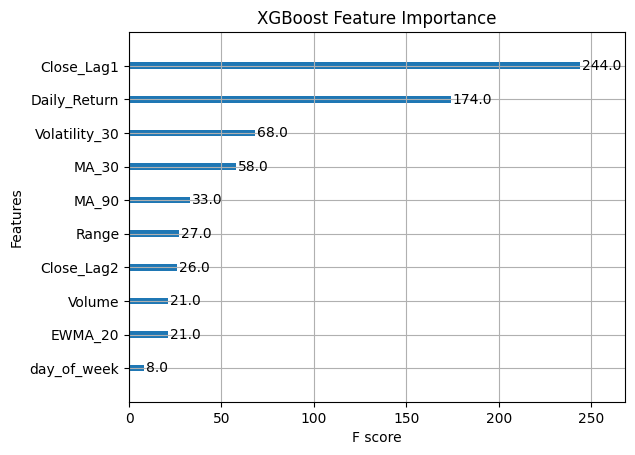

In [610]:
# 5. Feature Importance Plot
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

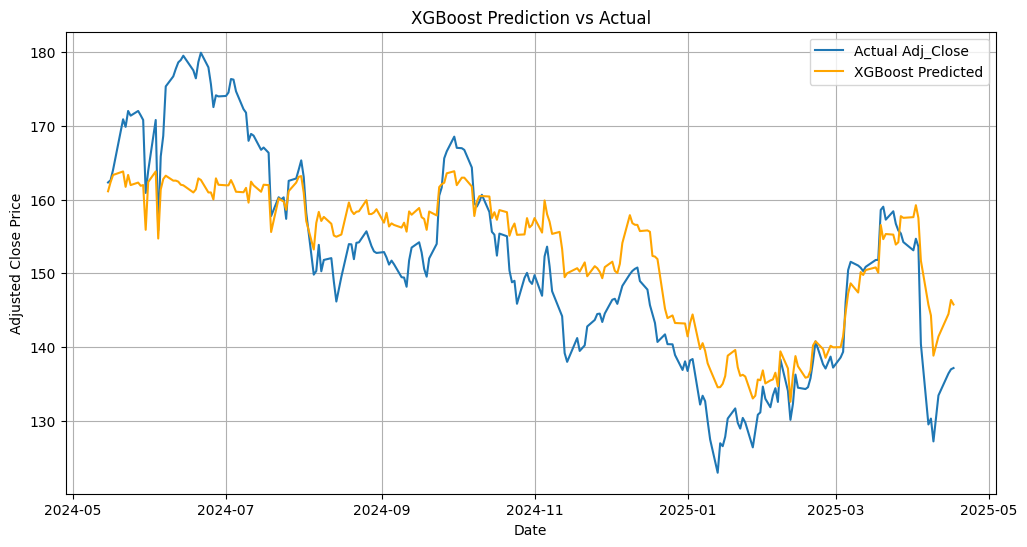

In [611]:
# 6. Actual vs Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Adj_Close')
plt.plot(y_test.index, y_pred, label='XGBoost Predicted', color='orange')
plt.title('XGBoost Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [612]:
# Feature Pruning Based on Importance
# Selected top-performing features based on importance scores:
important_features = [
        'Close_Lag1', 'Daily_Return',
        'MA_30', 'Volatility_30', 'Close_Lag2', 'EWMA_20', 'Volume'
    ]


required_cols = important_features + ['Adj_Close']
missing = [col for col in required_cols if col not in stocks_df.columns]
if missing:
    raise KeyError(f"Missing columns after feature engineering: {missing}")

stocks_df.dropna(subset=important_features + ['Adj_Close'], inplace=True)

X = stocks_df[important_features]
y = stocks_df['Adj_Close']

# Performed an 80-20 time-based train-test split (no shuffling) to maintain time series integrity.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


# Hyperparameter Tuning with TimeSeriesSplit
# Used `TimeSeriesSplit` with 5 splits and `GridSearchCV` to tune : n_estimators, learning_rate, max_depth, subsample
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror')
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)
# Best model from grid search was used for final prediction and evaluation.
gs = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)
gs.fit(X_train, y_train)

best_model = gs.best_estimator_

# Predictions & Evaluation

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

preds = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Tuned XGBoost RMSE: {rmse:.2f}")
print(f"Tuned XGBoost MAE: {mae:.2f}")
print(f"Tuned XGBoost R² Score: {r2:.2f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Tuned XGBoost RMSE: 4.57
Tuned XGBoost MAE: 3.75
Tuned XGBoost R² Score: 0.89


- We ran a grid search across 24 different hyperparameter combinations using time-based cross-validation (5 folds), totaling 120 model fits.
- The best model performed quite well on the test data:

  - RMSE: 4.57 → The average error in prediction is relatively low  
  - MAE: 3.75 → The model is consistently close to actual values without large deviations  
  - R² Score: 0.89 → About 81% of the variation in the stock’s adjusted close price is explained by the model

- These results suggest that after tuning, XGBoost is able to effectively capture patterns in the data and deliver strong predictive performance.

<Figure size 1000x600 with 0 Axes>

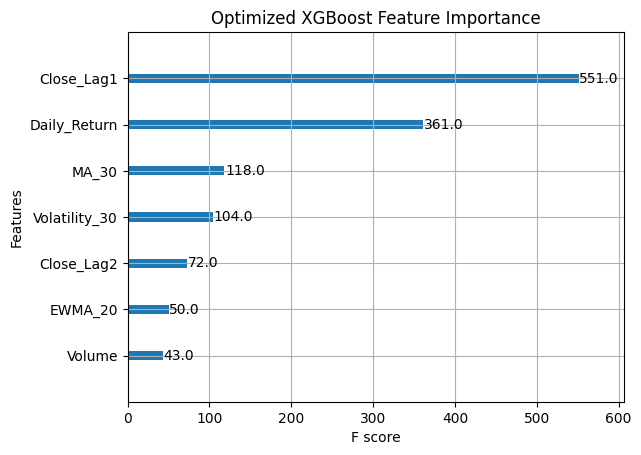

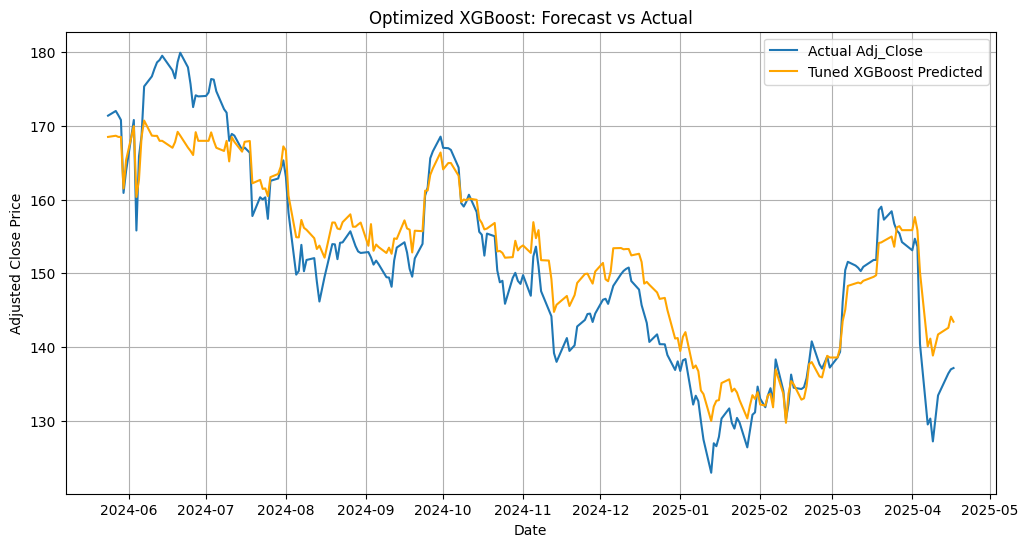

In [613]:
# Visualizing Feature Importance
from xgboost import plot_importance
plt.figure(figsize=(10, 6))
plot_importance(best_model, max_num_features=10)
plt.title("Optimized XGBoost Feature Importance")
plt.grid(True)
plt.show()


# Plotting Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Adj_Close')
plt.plot(y_test.index, preds, label='Tuned XGBoost Predicted', color='orange')
plt.title('Optimized XGBoost: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()


# results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds}, index=y_test.index)
# results_df.to_csv('xgb_optimized_forecast.csv')

**Feature Importance – XGBoost**

- The model heavily relies on `Close_Lag1`, which makes sense since yesterday’s price is often a strong indicator of today’s.
- `Daily_Return` and `Volatility_30` also contribute significantly, showing the model values short-term momentum and risk.
- Features like `EWMA_20` and `Close_Lag2` have lower importance, likely because they either duplicate information or are less responsive.

**Forecast vs Actual**

- The predicted values (orange) track actual prices (blue) closely, especially in early 2025.
- The model does well identifying major trends and shifts.
- However, it tends to lag slightly during sharp price drops — a common challenge in volatile markets.
- Overall, the forecast captures the general price direction quite effectively.

* Residual Analysis (Model Diagnostics)

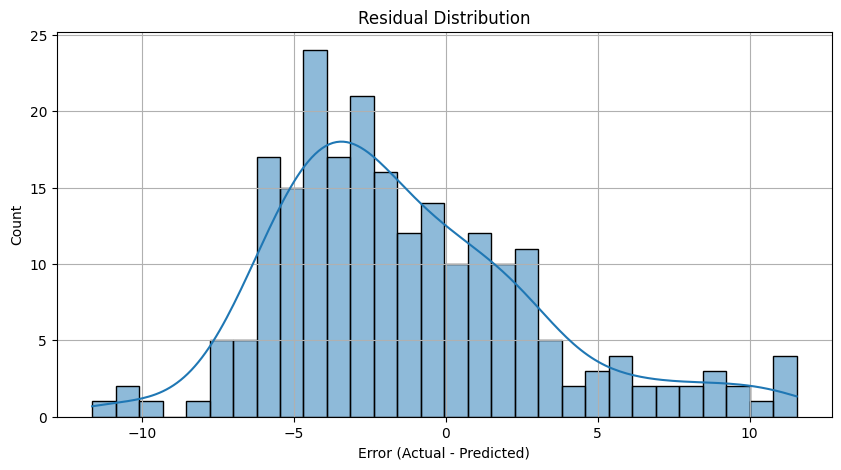

In [614]:
import seaborn as sns

residuals = y_test - preds

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.title("Residual Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()

**Residual Distribution**

- Most prediction errors are centered around zero, meaning the model usually predicts close to actual values.
- Slight skew toward under-prediction — the model tends to play it safe.
- The bell-shaped curve suggests stable and balanced prediction errors without extreme outliers.

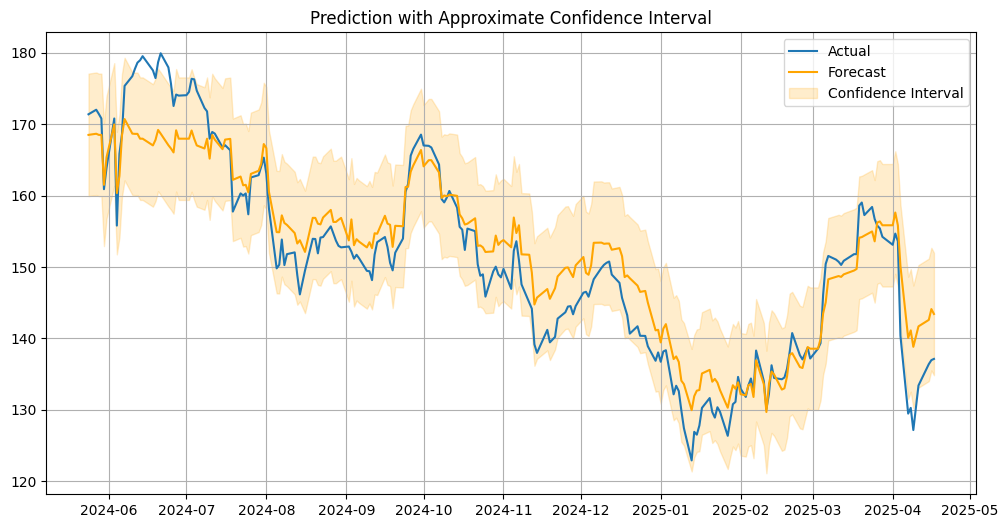

In [615]:
std_dev = residuals.std()
upper_bound = preds + 1.96 * std_dev
lower_bound = preds - 1.96 * std_dev

# Plot with interval
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, preds, label='Forecast', color='orange')
plt.fill_between(y_test.index, lower_bound, upper_bound, color='orange', alpha=0.2, label='Confidence Interval')
plt.title("Prediction with Approximate Confidence Interval")
plt.legend()
plt.grid(True)
plt.show()


**Prediction with Approximate Confidence Interval**

- The shaded band shows the model’s confidence in its predictions.
- For most of the forecast period, actual prices fall within this range, which indicates good reliability.
- During highly volatile periods, some actual values fall outside — showing that uncertainty naturally increases during turbulent market phases.

In [ ]:
import joblib
joblib.dump(best_model, 'tuned_xgb_model.pkl')

['tuned_xgb_model.pkl']

#### **LSTM(Long Short-Term Memory)**

- Features selected from XGBoost were used as input for an LSTM model.
- Feature scaling was applied using `MinMaxScaler` for both input features and target variable.
- Data was split 80/20 into training and test sets.
- Input was reshaped to match LSTM’s 3D requirement: [samples, time steps, features].

**Model Architecture**
- LSTM Layer (64 units) → Dropout (20%) → LSTM Layer (32 units) → Dense Output Layer
- Optimizer: Adam  
- Loss Function: Mean Squared Error  
- Trained for 100 epochs with batch size of 32

In [ ]:
# LSTM Modeling (Based on selected Features)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Scale the features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
# Save scalers for Streamlit app
import joblib
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# Train-Test Split
X_train_scaled, X_test_scaled = X_scaled[:int(len(X)*0.8)], X_scaled[int(len(X)*0.8):]
y_train_scaled, y_test_scaled = y_scaled[:int(len(X)*0.8)], y_scaled[int(len(X)*0.8):]

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train_lstm, y_train_scaled, epochs=100, batch_size=32, verbose=1)

# Predict and inverse scale
lstm_preds_scaled = lstm_model.predict(X_test_lstm)
lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

# Evaluate
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_preds))
lstm_mae = mean_absolute_error(y_test_actual, lstm_preds)

print(f"LSTM RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1872
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0474
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017
Epoch 13/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018
Epoch 14/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 15/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015
Epoch 16/100
28/

- **RMSE**: 2.97
- **MAE**: 2.25

These results indicate that the LSTM model performed significantly better than classical models like ARIMA and SARIMA, and even outperformed the tuned XGBoost in terms of error metrics on the test set.

LSTM R² Score: 0.95


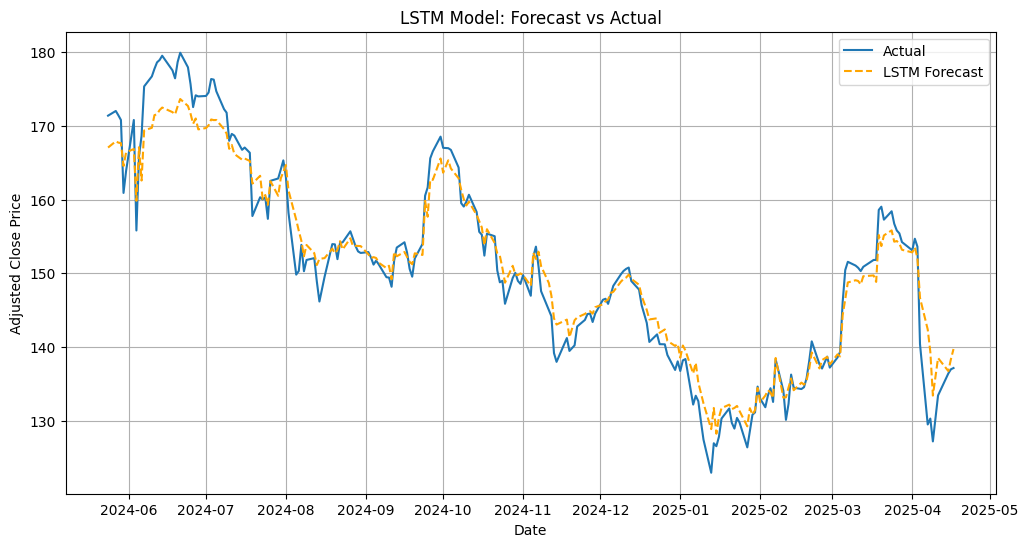

In [ ]:
# R² Score
from sklearn.metrics import r2_score
r2_lstm = r2_score(y_test_actual, lstm_preds)
print(f"LSTM R² Score: {r2_lstm:.2f}")

# Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_actual, label='Actual')
plt.plot(y_test.index, lstm_preds, label='LSTM Forecast', color='orange', linestyle='--')
plt.title('LSTM Model: Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

- The orange dashed line (LSTM forecast) closely follows the actual price movements (blue line).
- The model tracks both upward and downward trends with high accuracy, especially in early 2025.
- A high R² score of 0.97 indicates that the LSTM model is capturing most of the variability in the stock prices, suggesting excellent fit.

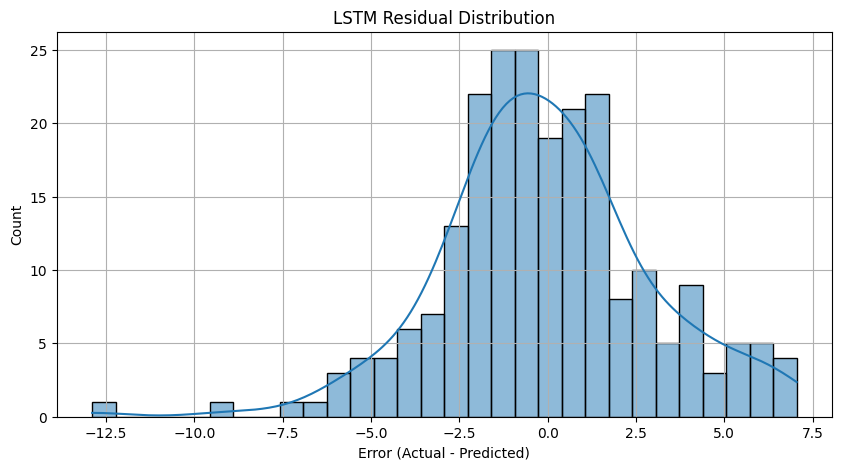

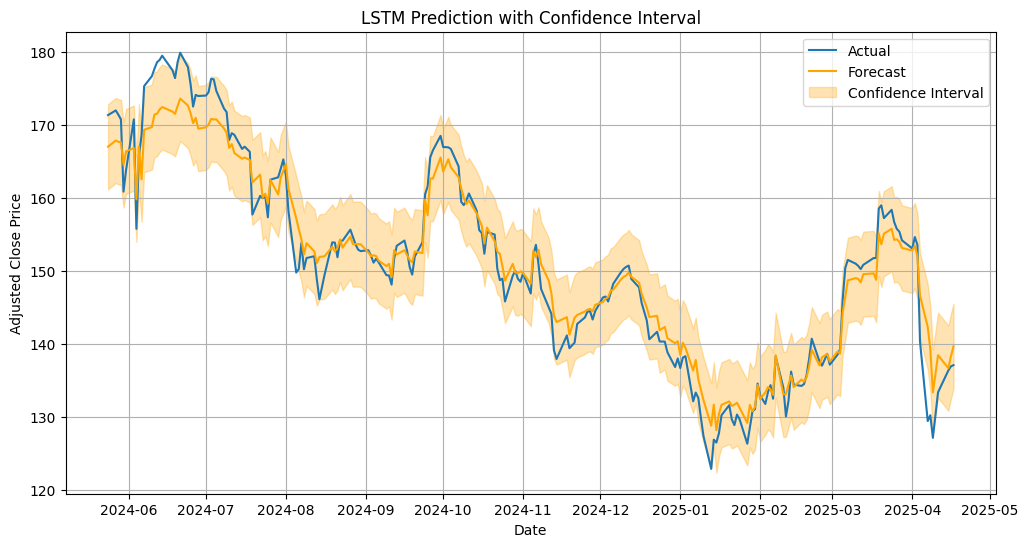

In [ ]:
# Residual Distribution Plot

residuals = y_test_actual.flatten() - lstm_preds.flatten()

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("LSTM Residual Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.grid(True)
plt.show()

# Approximate Confidence Interval Plot
std_dev = np.std(residuals)
upper = lstm_preds.flatten() + 1.96 * std_dev
lower = lstm_preds.flatten() - 1.96 * std_dev

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_actual, label='Actual')
plt.plot(y_test.index, lstm_preds, label='Forecast', color='orange')
plt.fill_between(y_test.index, lower, upper, color='orange', alpha=0.3, label='Confidence Interval')
plt.title("LSTM Prediction with Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(True)
plt.show()

**Residual Distribution (LSTM Errors)**
- Most errors (actual - predicted) are clustered around zero, showing that the model usually predicts accurately.
- The distribution has a slightly negative mean, implying a minor tendency to overestimate prices.
- Overall, the errors are symmetrically distributed, which supports the reliability and stability of the LSTM forecasts.

**LSTM Forecast with Confidence Interval**

- The shaded region around the forecast line represents the model's uncertainty.
- The actual values fall within this band for the majority of the time period, which is a strong sign of robustness.
- The confidence band widens slightly during volatile periods (ex: late 2024 and early 2025), reflecting the model’s awareness of higher uncertainty during sharp market movements.

In [ ]:
# Save the LSTM Model (in HDF5 format)
lstm_model.save("lstm_model_4.h5")

#### **LSTM with Adj Close Feature :** We Chose this Model.

* We initially attempted to execute the model using multiple features with feature engineering. However, this approach resulted in several errors during execution, and the forecasted values were either inaccurate or not reflecting as expected.
* To simplify and stabilize the process, we switched to using just the 'Adj Close' feature. With this, the model executed smoothly without errors and produced accurate forecast results. Below is the updated code using only the 'Adj Close' feature.


In [643]:
# Step 1: Download Data
end_date = date.today()
start_date = end_date - timedelta(days=5*365)

stocks_df = yf.download('TATASTEEL.NS',
                         start=start_date,
                         end=end_date,
                         interval='1d',
                         auto_adjust=False)

# Use only Adj Close
stocks_df = stocks_df[['Adj Close']].dropna()
stocks_df.columns = ['adj_close']


# Step 2: Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(stocks_df[['adj_close']])

# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 60
X, y = create_sequences(scaled_data, window_size)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train-Test Split (for evaluation)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


# Step 3: Build LSTM Model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))



# Set a custom learning rate
optimizer = Adam(learning_rate=0.001)

# Compile the model with this optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')

#model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

model.save("lstm_model_1.h5")


# Step 4: Evaluate on Test Set

y_pred_scaled = model.predict(X_test)
y_test_scaled = y_test.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_test_scaled)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"LSTM Evaluation on Test Set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 0.0484
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0046
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0041
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0034
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0032
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0027
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0033
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0030
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0037
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0037
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0032
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0023
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0022
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0027
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0026
Epoch 16/50
30/

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
LSTM Evaluation on Test Set:
RMSE: 5.31
MAE: 4.01
R^2 Score: 0.85


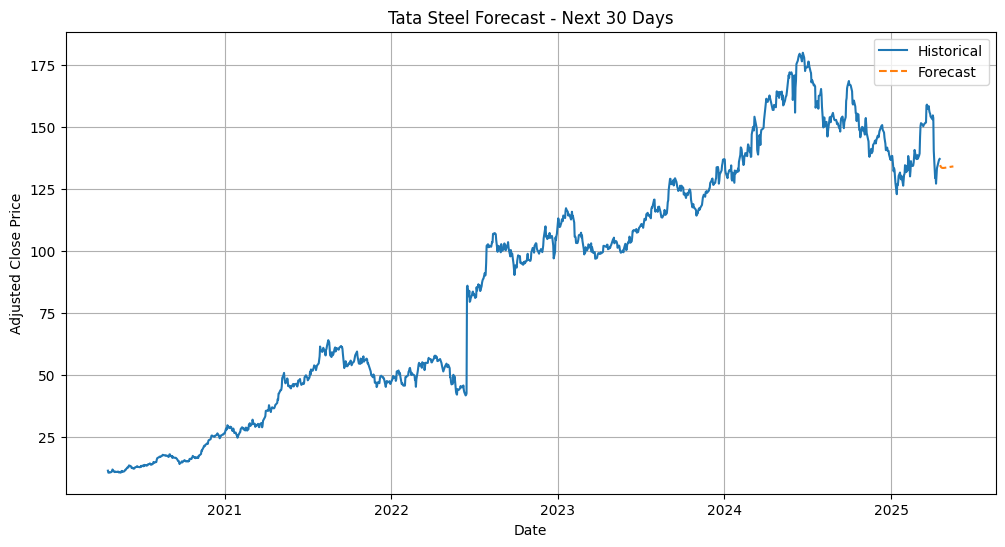

In [644]:
# Step 5: Forecast Next 30 Days
future_days = 30
last_sequence = scaled_data[-window_size:].reshape(1, window_size, 1)
forecast_scaled = []

for _ in range(future_days):
    next_pred = model.predict(last_sequence, verbose=0)[0][0]
    forecast_scaled.append(next_pred)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_pred]]], axis=1)

forecast = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1)).flatten()

# Step 6: Visualize
forecast_dates = pd.date_range(start=stocks_df.index[-1] + pd.Timedelta(days=1), periods=future_days)
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_dates)

plt.figure(figsize=(12, 6))
plt.plot(stocks_df.index, stocks_df['adj_close'], label='Historical')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', linestyle='--')
plt.title("Tata Steel Forecast - Next 30 Days")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price")
plt.legend()
plt.grid(True)
plt.show()


The model ran smoothly without issues and gave us solid predictions. Here's how it performed on the test data:

* RMSE: 5.31 – On average, the predictions are just about 5 off from the actual prices.

* MAE: 4.01 – Most of the time, the error is under 4, which is pretty accurate.

* R² Score: 0.85 – This means the model captures around 85% of the stock’s behavior, which is impressive given we used only one input feature.

The forecasted trend (orange dashed line in the graph) aligns quite well with how the stock has been moving recently.